In [1]:
import sys
sys.path.append('C:/QCodes drivers and scripts/Drivers')

from PLH250P_current_source_dummy import TTi
from PLH250P_current_source_TCP import current_set,power_up as current_source_on,power_down as current_source_off
current_source = TTi('TTi')


from RS_SMB_100A import SMB100A


MW_source_1_SNTJ = SMB100A('SMB100A_1', 'TCPIP0::192.168.0.53::inst0::INSTR')


# from RS_FSQ import RS_FSQ
# RS_SA_SNTJ = RS_FSQ('RS_FSQ', 'TCPIP0::192.168.0.61::inst0::INSTR')

from RS_FSV import RS_FSV
RS_SA_SNTJ = RS_FSV('RS_FSQ', 'TCPIP0::192.168.10.66::inst0::INSTR')

Connected to: Dummy corp current source 001 (serial:dummy 100, firmware:None) in 0.00s
Connected to: Rohde&Schwarz SMB100A (serial:1406.6000k03/177960, firmware:3.1.18.2-3.01.203.32) in 0.07s
Connected to: Rohde&Schwarz FSV3030 (serial:1330.5000K30/101509, firmware:1.60) in 0.02s


In [2]:
print('Is the SNTJ grounded? (y/n)')

warning = input()
if warning == 'y':
    from Yokogawa_7651 import Yokogawa_7651
    Yokogawa_7651_SNTJ = Yokogawa_7651('Yokogawa_7651', 'GPIB0::4::INSTR')
    # Yokogawa_7651_SNTJ = Yokogawa_7651('Yokogawa_7651', 'TCPIP0::192.168.1.253::gpib0::INSTR')

Is the SNTJ grounded? (y/n)
y


In [3]:
Yokogawa_7651_SNTJ.voltage_range(100)
Yokogawa_7651_SNTJ.voltage_limit(1000)
Yokogawa_7651_SNTJ.current_limit(5)

Yokogawa_7651_SNTJ.status('on')
print('Success: SNTJ can be connected')

Success: SNTJ can be connected


In [4]:
import qcodes as qc
from qcodes.logger.logger import start_all_logging
import datetime
from qcodes.dataset.plotting import plot_dataset
import numpy as np
import matplotlib.pyplot as plt
#qcodes.config.subscription.default_subscribers = ["Plottr"]
from time import sleep

from pprint import pprint
import json


sys.path.append('C:\QCodes drivers and scripts\Scripts\Arpit\Modules')
from notify import snotify
from progress_barV2 import bar
from general_functions import find_nearest

In [5]:
%matplotlib notebook

In [6]:
start_all_logging()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\nicolas.roch\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\nicolas.roch\.qcodes\logs\220119-8048-qcodes.log


In [7]:
#create a station
station = qc.Station()
station.add_component(current_source)
# station.add_component(MW_source_1_SNTJ)
station.add_component(RS_SA_SNTJ)
station.add_component(Yokogawa_7651_SNTJ)
station.snapshot()
station.components

{'TTi': <TTi: TTi>,
 'RS_FSQ': <RS_FSV: RS_FSQ>,
 'Yokogawa_7651': <Yokogawa_7651: Yokogawa_7651>}

In [8]:
experiment_file = open('C:/QCodes drivers and scripts/Scripts/Arpit/_experiment_details.txt','r')
experiment = experiment_file.readlines()
experiment=json.loads(''.join(experiment))

user = experiment['details']['user']
# date = experiment['details']['date']
date = '-'.join(str(datetime.date.today()).split('-'))
description = experiment['details']['description']
cooldown = experiment['details']['cooldown']
database_name = date+"_"+'CD_'+cooldown+'_'+user+"_"+description
database_name

qc.initialise_or_create_database_at("D:/Data_QCodes/"+database_name)
qc.config.core.db_location

'D:/Data_QCodes/2022-01-19_CD_19_01_GC_RK TWPAs and SJ TWPA'

In [9]:
device_ids = experiment['device_ids']

In [28]:
parameter_snap={}

# MW Source
pump_frequency = 8
pump_power = 0
# pump_status = 'on'
pump_status = 'off'
parameter_snap['pump']={'pump_frequency':pump_frequency,'pump_power':pump_power,'pump_status':pump_status}
    
# Signal Analyzer
averages = 1
resolution_BW = 40e6
video_BW = 200
ref_level = 0
# freq_center = pump_frequency
freq_center = 8
span = 10
# start_freq = freq_center-(span)/2.
# end_freq = freq_center+(span)/2.
start_freq = 3
end_freq = 13
points = 201
input_att = 0

parameter_snap['spectrum analyser']={'resolution_BW':resolution_BW,'video_BW':video_BW,'ref_level':ref_level,'start_freq':start_freq,'end_freq':end_freq,'points':points, 'input_att': input_att, 'averages': averages}

# Current source
I = 0

parameter_snap['flux']={'I':I}

# Yokogawa 
SNTJ_resistance = 54.
voltage_max = 250 #400
voltage_points = 101 #31
v_vec = np.linspace(-(voltage_max),(voltage_max),voltage_points)
# v_vec = np.linspace(-(100),(150),voltage_points)
# v_vec2 = np.linspace(+(voltage_max),-(voltage_max),voltage_points)
# v_vec=np.append(v_vec1,v_vec2)
v_shift = 0### uV


# v_vec_log = np.linspace(0,np.log10(voltage_max+1),voltage_points)
# v_vec_pos = 10**(v_vec_log)-1
# v_vec_neg = -v_vec_pos[::-1]
# v_vec = np.append(v_vec_neg[:-1],v_vec_pos) + v_shift
v_vec_mV = (v_vec + v_shift)*10/SNTJ_resistance 
parameter_snap['SNTJ']={'SNTJ_resistance':SNTJ_resistance,'voltage_max':voltage_max,'voltage_points':voltage_points, 'v_shift':v_shift}
# print('v_vec: ', v_vec)

# current_source_on()
# current_set(I)

# MW_source_1_SNTJ.frequency(pump_frequency*1e9)
# MW_source_1_SNTJ.power(pump_power)
# MW_source_1_SNTJ.phase(0)
# MW_source_1_SNTJ.status(pump_status)

# RS_SA_SNTJ.averages(averages)
# RS_SA_SNTJ.res_BW(resolution_BW)
# RS_SA_SNTJ.video_BW(video_BW)
# RS_SA_SNTJ.ref_level(ref_level)
# RS_SA_SNTJ.f_start(start_freq*1e9)
# RS_SA_SNTJ.f_stop(end_freq*1e9)
# RS_SA_SNTJ.n_points(points)
# RS_SA_SNTJ.input_att(input_att)

# Yokogawa_7651_SNTJ.voltage_range(100)
# Yokogawa_7651_SNTJ.voltage_limit(1000)
# Yokogawa_7651_SNTJ.current_limit(5)
# Yokogawa_7651_SNTJ.voltage(0)
# Yokogawa_7651_SNTJ.status('on')

In [29]:
v_vec_mV

array([-46.2962963 , -45.37037037, -44.44444444, -43.51851852,
       -42.59259259, -41.66666667, -40.74074074, -39.81481481,
       -38.88888889, -37.96296296, -37.03703704, -36.11111111,
       -35.18518519, -34.25925926, -33.33333333, -32.40740741,
       -31.48148148, -30.55555556, -29.62962963, -28.7037037 ,
       -27.77777778, -26.85185185, -25.92592593, -25.        ,
       -24.07407407, -23.14814815, -22.22222222, -21.2962963 ,
       -20.37037037, -19.44444444, -18.51851852, -17.59259259,
       -16.66666667, -15.74074074, -14.81481481, -13.88888889,
       -12.96296296, -12.03703704, -11.11111111, -10.18518519,
        -9.25925926,  -8.33333333,  -7.40740741,  -6.48148148,
        -5.55555556,  -4.62962963,  -3.7037037 ,  -2.77777778,
        -1.85185185,  -0.92592593,   0.        ,   0.92592593,
         1.85185185,   2.77777778,   3.7037037 ,   4.62962963,
         5.55555556,   6.48148148,   7.40740741,   8.33333333,
         9.25925926,  10.18518519,  11.11111111,  12.03

In [14]:
# RS_SA_SNTJ.set_harmonic('OFF')

In [15]:
experiment_file = open('C:\QCodes drivers and scripts\Scripts\Arpit\_experiment_details.txt','r')
experiment = experiment_file.readlines()
experiment = json.loads(''.join(experiment))
switch_position = experiment['current_device']['current_device']

exp_name = 'SNTJ noise calibration'
sample_name = device_ids[switch_position]
exp=qc.load_or_create_experiment(experiment_name=exp_name,
                          sample_name=sample_name)

meas = qc.Measurement(exp=exp, station=station)
meas.register_parameter(Yokogawa_7651_SNTJ.voltage) 
meas.register_parameter(RS_SA_SNTJ.spectrum,setpoints=(Yokogawa_7651_SNTJ.voltage,))
meas.write_period = 2


with meas.run() as datasaver:
    for volt_mV in bar(v_vec_mV):
        Yokogawa_7651_SNTJ.voltage(volt_mV)
        sleep(1)
        datasaver.add_result((Yokogawa_7651_SNTJ.voltage, volt_mV),(RS_SA_SNTJ.freq_axis, RS_SA_SNTJ.freq_axis()),(RS_SA_SNTJ.spectrum,RS_SA_SNTJ.spectrum()))

id=datasaver.dataset.run_id
qc.load_by_run_spec( captured_run_id=id).add_metadata('parameter_snap',json.dumps(parameter_snap))

Yokogawa_7651_SNTJ.voltage(0)

Starting experimental run with id: 3. 


In [13]:
pump_param_arr = [(9.4,6.4),(9.4,7),(5.9,4.5),(5.9,5.1),(5.9,4),(7,4),(7,5),(7,5.3)]  #(freq, power)

for i_num in bar(range(len(pump_param_arr))):

    parameter_snap={}

    # MW Source
    pump_frequency = pump_param_arr[i_num][0]
    pump_power = pump_param_arr[i_num][1]
    pump_status = 'on'
    # pump_status = 'off'
    parameter_snap['pump']={'pump_frequency':pump_frequency,'pump_power':pump_power,'pump_status':pump_status}

    # Signal Analyzer
    averages = 1
    resolution_BW = 50e6
    video_BW = 50
    ref_level = 0
    freq_center = pump_frequency
    span = 6
    start_freq = freq_center-(span)/2.
    end_freq = freq_center+(span)/2.
    # start_freq = 7
    # end_freq = 13
    points = 201
    input_att = 0

    parameter_snap['spectrum analyser']={'resolution_BW':resolution_BW,'video_BW':video_BW,'ref_level':ref_level,'start_freq':start_freq,'end_freq':end_freq,'points':points, 'input_att': input_att, 'averages': averages}

    # Current source
    I = 0

    parameter_snap['flux']={'I':I}

    # Yokogawa 
    SNTJ_resistance = 54.
    voltage_max = 200 #400
    voltage_points = 401 #31
    v_vec = np.linspace(-(voltage_max),(voltage_max),voltage_points)
    # v_vec = np.linspace(-(100),(150),voltage_points)
    # v_vec2 = np.linspace(+(voltage_max),-(voltage_max),voltage_points)
    # v_vec=np.append(v_vec1,v_vec2)
    v_shift = 30### uV


    # v_vec_log = np.linspace(0,np.log10(voltage_max+1),voltage_points)
    # v_vec_pos = 10**(v_vec_log)-1
    # v_vec_neg = -v_vec_pos[::-1]
    # v_vec = np.append(v_vec_neg[:-1],v_vec_pos) + v_shift
    v_vec_mV = (v_vec + v_shift)*10/SNTJ_resistance 
    parameter_snap['SNTJ']={'SNTJ_resistance':SNTJ_resistance,'voltage_max':voltage_max,'voltage_points':voltage_points, 'v_shift':v_shift}
#     print('v_vec: ', v_vec)

    current_source_on()
    current_set(I)

    MW_source_1_SNTJ.frequency(pump_frequency*1e9)
    MW_source_1_SNTJ.power(pump_power)
    MW_source_1_SNTJ.phase(0)
    MW_source_1_SNTJ.status(pump_status)

    RS_SA_SNTJ.averages(averages)
    RS_SA_SNTJ.res_BW(resolution_BW)
    RS_SA_SNTJ.video_BW(video_BW)
    RS_SA_SNTJ.ref_level(ref_level)
    RS_SA_SNTJ.f_start(start_freq*1e9)
    RS_SA_SNTJ.f_stop(end_freq*1e9)
    RS_SA_SNTJ.n_points(points)
    RS_SA_SNTJ.input_att(input_att)

    Yokogawa_7651_SNTJ.voltage_range(100)
    Yokogawa_7651_SNTJ.voltage_limit(1000)
    Yokogawa_7651_SNTJ.current_limit(5)
    Yokogawa_7651_SNTJ.voltage(0)
    Yokogawa_7651_SNTJ.status('on')

    experiment_file = open('C:\QCodes drivers and scripts\Scripts\Arpit\_experiment_details.txt','r')
    experiment = experiment_file.readlines()
    experiment = json.loads(''.join(experiment))
    switch_position = experiment['current_device']['current_device']

    exp_name = 'SNTJ noise calibration'
    sample_name = device_ids[switch_position]
    exp=qc.load_or_create_experiment(experiment_name=exp_name,
                              sample_name=sample_name)

    meas = qc.Measurement(exp=exp, station=station)
    meas.register_parameter(Yokogawa_7651_SNTJ.voltage) 
    meas.register_parameter(RS_SA_SNTJ.spectrum,setpoints=(Yokogawa_7651_SNTJ.voltage,))
    meas.write_period = 2


    with meas.run() as datasaver:
        for volt_mV in bar(v_vec_mV):
            Yokogawa_7651_SNTJ.voltage(volt_mV)
            sleep(1)
            datasaver.add_result((Yokogawa_7651_SNTJ.voltage, volt_mV),(RS_SA_SNTJ.freq_axis, RS_SA_SNTJ.freq_axis()),(RS_SA_SNTJ.spectrum,RS_SA_SNTJ.spectrum()))

    id=datasaver.dataset.run_id
    qc.load_by_run_spec( captured_run_id=id).add_metadata('parameter_snap',json.dumps(parameter_snap))

    Yokogawa_7651_SNTJ.voltage(0)

Starting experimental run with id: 2. 


Starting experimental run with id: 3. 


Starting experimental run with id: 4. 


Starting experimental run with id: 5. 


Starting experimental run with id: 6. 


Starting experimental run with id: 7. 


Starting experimental run with id: 8. 


Starting experimental run with id: 9. 


In [44]:
captured_run_id = 34
dataset = qc.load_by_run_spec(captured_run_id=captured_run_id)
dataset

results #56@D:\Data_QCodes\2021-09-27_CD_24_09_AR_ME_GC_3WM and 4WM SNAIL TWPAs
-------------------------------------------------------------------------------
Yokogawa_7651_voltage - numeric
RS_FSQ_freq_axis - array
RS_FSQ_spectrum - array

In [45]:
voltage = dataset.get_parameter_data('Yokogawa_7651_voltage')['Yokogawa_7651_voltage']['Yokogawa_7651_voltage']*SNTJ_resistance/10.
freq_data = dataset.get_parameter_data('RS_FSQ_freq_axis')['RS_FSQ_freq_axis']['RS_FSQ_freq_axis'][0]*1e-9
spectrum = (dataset.get_parameter_data('RS_FSQ_spectrum')['RS_FSQ_spectrum']['RS_FSQ_spectrum'])#.reshape(len(flux_data),len(freq_data))

In [46]:
if True: #load meta

    meta = json.loads(dataset.get_metadata('parameter_snap'))
    pump_frequency = meta['pump']['pump_frequency']
    pump_power = meta['pump']['pump_power']
    pump_status = meta['pump']['pump_status']
    resolution_BW = meta['spectrum analyser']['resolution_BW']
    video_BW = meta['spectrum analyser']['video_BW']
    ref_level = meta['spectrum analyser']['ref_level']
    start_freq = meta['spectrum analyser']['start_freq']
    end_freq = meta['spectrum analyser']['end_freq']
    points = meta['spectrum analyser']['points']
    I = meta['flux']['I']
    SNTJ_resistance = meta['SNTJ']['SNTJ_resistance']
    voltage_max = meta['SNTJ']['voltage_max']
    voltage_points = meta['SNTJ']['voltage_points']
    
    exp_name = dataset.exp_name
    sample_name = dataset.sample_name

In [47]:
# freq_data

<IPython.core.display.Javascript object>


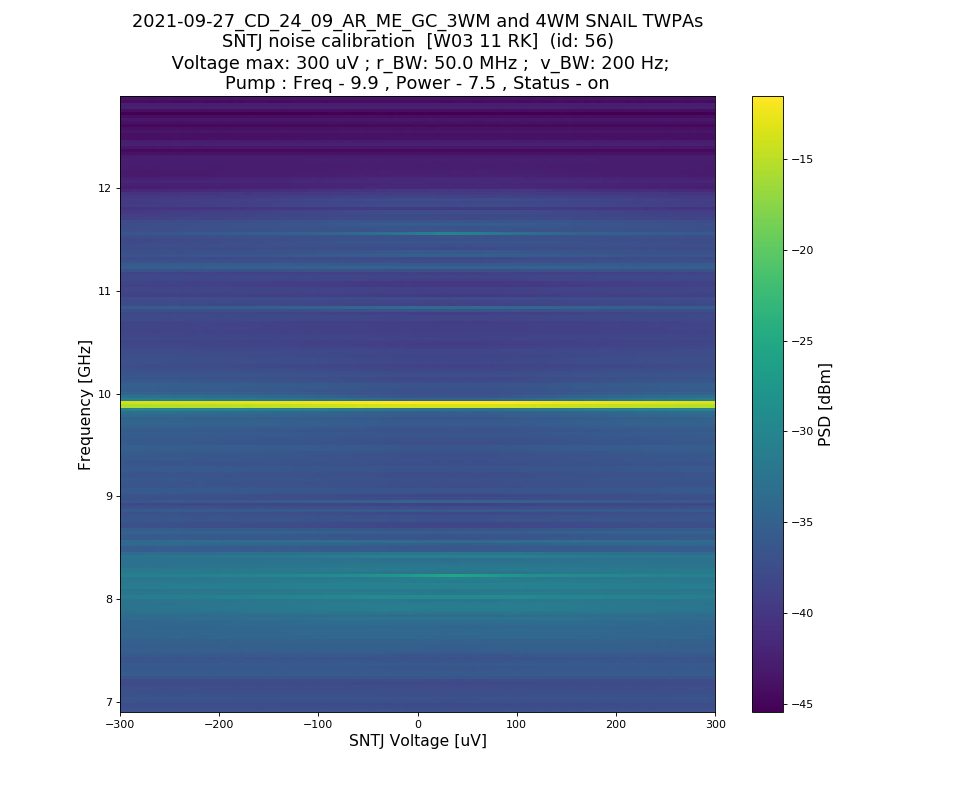

In [48]:
plot_title=database_name+'\n'+exp_name+'  ['+sample_name+']  (id: '+str(captured_run_id)+')'
plot_title+='\n Voltage max: '+str(voltage_max)+' uV ;'+' r_BW: '+str(resolution_BW/1e6)+' MHz ;  v_BW: '+str(video_BW)+' Hz;'
plot_title+='\nPump : Freq - '+str(pump_frequency) + ' , Power - '+str(pump_power)+' , Status - '+str(pump_status)

plt.figure(figsize=(12, 10), dpi= 80) #facecolor='w', edgecolor='k'

X, Y = np.meshgrid(np.array(voltage),np.array(freq_data))
Z = spectrum.T
plt.pcolor(X, Y, Z)
# plt.pcolor(X, Y, Z, vmin=-80, vmax=-60)
cbar=plt.colorbar()
cbar.set_label('PSD [dBm]', size=14)

plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12*1.2)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12*1.2)  

x_label='SNTJ Voltage [uV]'
y_label='Frequency [GHz]'
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)
plt.title(plot_title, size=16)

plt.show()

<IPython.core.display.Javascript object>


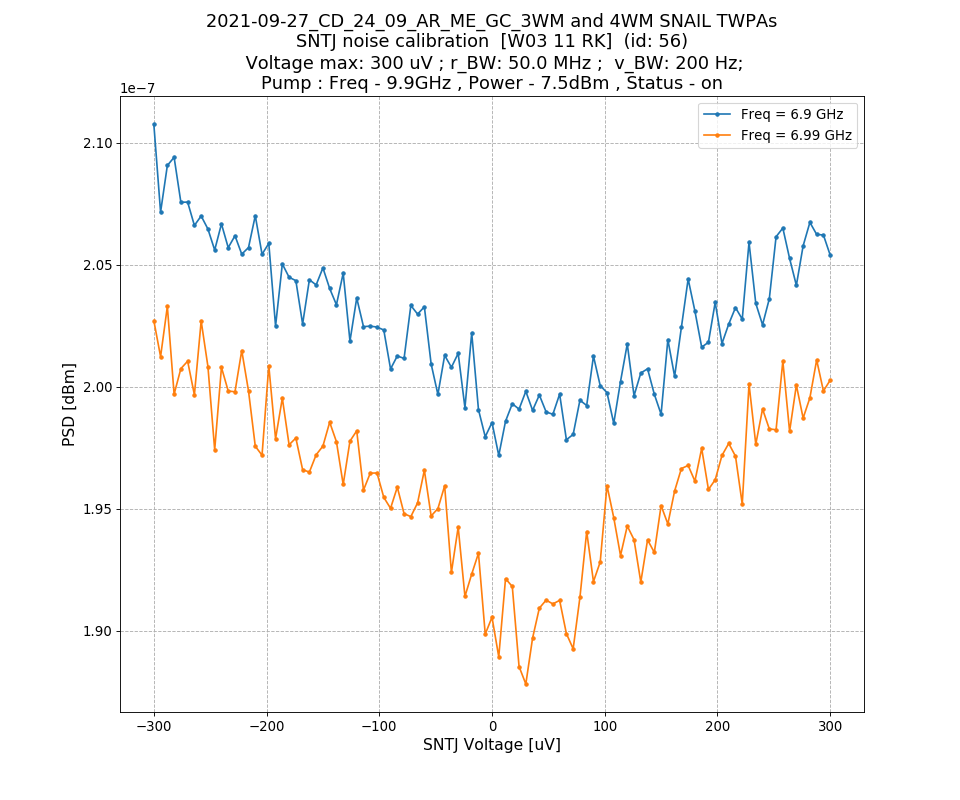

In [49]:
freq_list=np.array([5.5, 7])
def dBm_to_Watts(dBm):
    return 10**(dBm/10.)*1e-3
plot_title=database_name+'\n'+exp_name+'  ['+sample_name+']  (id: '+str(captured_run_id)+')'
plot_title+='\n Voltage max: '+str(voltage_max)+' uV ;'+' r_BW: '+str(resolution_BW/1e6)+' MHz ;  v_BW: '+str(video_BW)+' Hz;'
plot_title+='\nPump : Freq - '+str(pump_frequency) + 'GHz , Power - '+str(pump_power)+'dBm , Status - '+str(pump_status)


plt.figure(figsize=(12, 10), dpi= 80) #facecolor='w', edgecolor='k'
x_label='SNTJ Voltage [uV]'
y_label='PSD [dBm]'

plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('grid', linestyle="--")
plt.grid(True)

for freq in freq_list:
    freq_index = find_nearest(freq_data,freq)
    plt.plot(voltage,dBm_to_Watts(spectrum.T[freq_index]),label='Freq = '+str(freq_data[freq_index])+' GHz',marker=".")#marker="."
    
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)
plt.title(plot_title, size=16)

plt.legend(fontsize = 12)
# plt.xlim(3, 12)
# plt.ylim(-6, 30)
plt.show()    

<IPython.core.display.Javascript object>


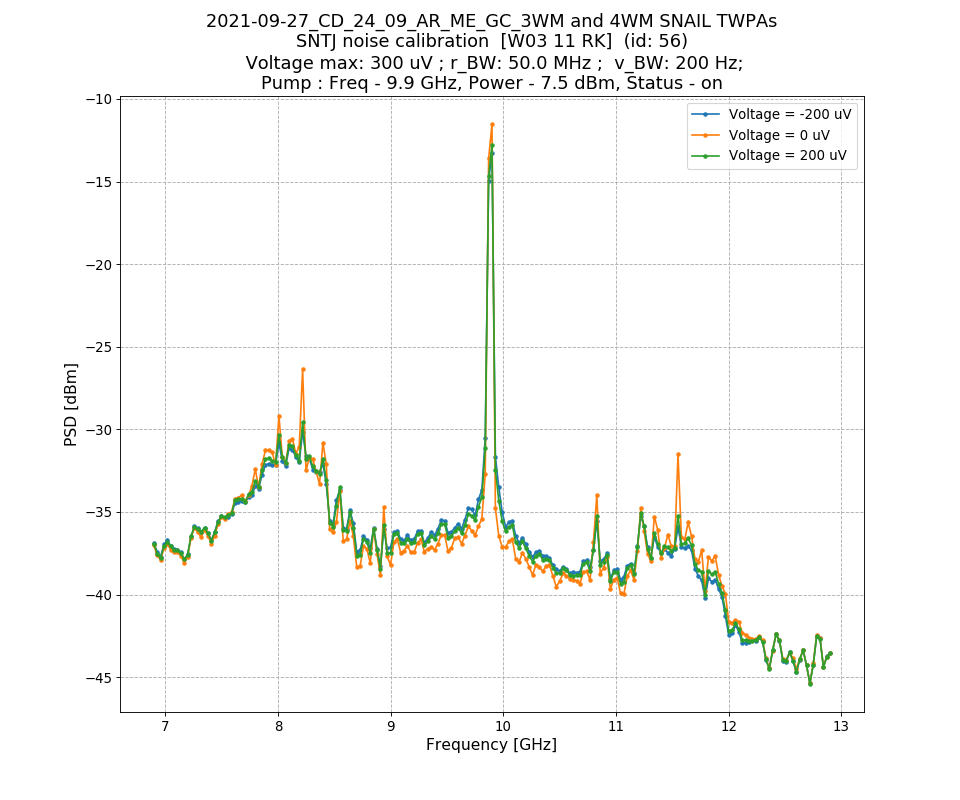

In [50]:
voltage_list=np.array([-200,0,200])

plot_title=database_name+'\n'+exp_name+'  ['+sample_name+']  (id: '+str(captured_run_id)+')'
plot_title+='\n Voltage max: '+str(voltage_max)+' uV ;'+' r_BW: '+str(resolution_BW/1e6)+' MHz ;  v_BW: '+str(video_BW)+' Hz;'
plot_title+='\nPump : Freq - '+str(pump_frequency) + ' GHz, Power - '+str(pump_power)+' dBm, Status - '+str(pump_status)


plt.figure(figsize=(12, 10), dpi= 80) #facecolor='w', edgecolor='k'
x_label='Frequency [GHz]'
y_label='PSD [dBm]'

plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('grid', linestyle="--")
plt.grid(True)

for voltage_pt in voltage_list:
    plt.plot(freq_data,spectrum[find_nearest(voltage,voltage_pt)],label='Voltage = '+str(voltage_pt)+' uV',marker=".")#marker="."
    
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)
plt.title(plot_title, size=16)

plt.legend(fontsize = 12)
# plt.xlim(3, 12)
# plt.ylim(-6, 30)
plt.show()    